# Time Series Analysis & Recurrent Neural Networks
## Final Project
### Lars Kühmichel, Nicolas Wolf

The final project is about analyzing the dynamics of a time series of weather data from across Europe. The goal is to
- reconstruct the dynamics behind the data, especially the annual and daily rhythms
- predict the future of the time series
- and compare two model architectures with respect to the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as pl
import seaborn as sns
import torch
import torch.nn as nn
import pytorch_lightning as lightning
import pytorch_lightning.loggers as loggers
from torch.utils.data import DataLoader, Dataset

import ray.tune as tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback

/home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rc("figure", dpi=200)
plt.rc("legend", fontsize=6)

We first run a modified version of the provided code to download the dataset and save it locally.

In [3]:
def running_mean(x, N):
    w = np.ones(N) / N
    if x.ndim > 1:
        res = []
        for i in range(x.shape[1]):
            res.append(np.convolve(w, x[:, i], 'valid'))
        return np.array(res).T
    else:
        return np.convolve(w, x, 'valid')

In [4]:
data_root = pl.Path("data")
data_root.mkdir(exist_ok=True, parents=True)

data_path = data_root / "weather_data.csv"

if not data_path.is_file():
    data_url = r"https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv"
    data = pd.read_csv(data_url)
    data.to_csv(data_path)
else:
    data = pd.read_csv(data_path)

The dataset contains hourly geographically aggregated weather (radiation and temperature) data for Europe. It covers the European countries using a population-weighted mean across all MERRA-2 grid cells within the given country.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 86 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       350640 non-null  int64  
 1   utc_timestamp                    350640 non-null  object 
 2   AT_temperature                   350640 non-null  float64
 3   AT_radiation_direct_horizontal   350640 non-null  float64
 4   AT_radiation_diffuse_horizontal  350640 non-null  float64
 5   BE_temperature                   350640 non-null  float64
 6   BE_radiation_direct_horizontal   350640 non-null  float64
 7   BE_radiation_diffuse_horizontal  350640 non-null  float64
 8   BG_temperature                   350640 non-null  float64
 9   BG_radiation_direct_horizontal   350640 non-null  float64
 10  BG_radiation_diffuse_horizontal  350640 non-null  float64
 11  CH_temperature                   350640 non-null  float64
 12  CH

In [6]:
keys = [
    "FI_temperature",
    "DE_temperature",
    "GR_temperature"
]

test_temp = data[keys]

In [7]:
ten_years = 24 * 365 * 10
tdf = test_temp[-ten_years:]

In [8]:
# weekly mask
week_filter = [True] * 24 + [False] * 24 * 6
# yearly mask for 52 weeks plus one day
year_filter = week_filter * 52 + [True] * 24
# mask for ten years
ten_years_filter = year_filter * 10
daydf = tdf[ten_years_filter]

daydf.shape

(12720, 3)

In [9]:
npa = daydf.to_numpy()

In [10]:
#Moving average to see both trends
N = 24
mnpa = running_mean(npa, N)

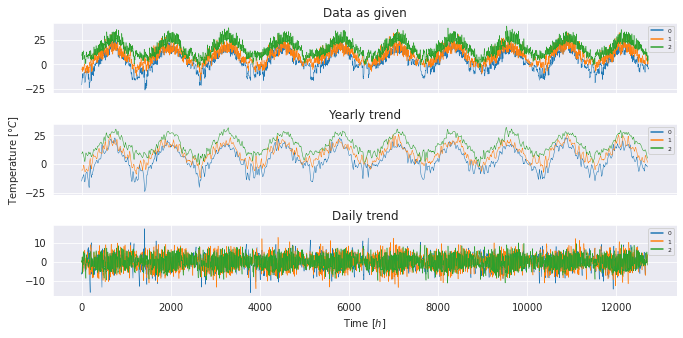

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex="all", figsize=plt.figaspect(1 / 2))
sns.lineplot(data=npa, ax=axes[0], dashes=False, lw=0.5)
axes[0].set_title("Data as given")

sns.lineplot(data=mnpa, ax=axes[1], dashes=False, lw=0.5)
axes[1].set_title("Yearly trend")
axes[1].set_ylabel("Temperature $[°C]$")

sns.lineplot(data=npa[:-N + 1] - mnpa, ax=axes[2], dashes=False, lw=0.5)
axes[2].set_title("Daily trend")
axes[2].set_xlabel("Time $[h]$")

plt.tight_layout()

Split into train and test set

In [12]:
pivot = int(0.8 * len(npa))

train_data, test_data = npa[:pivot], npa[pivot:]

train_data.shape, test_data.shape

((10176, 3), (2544, 3))

Normalize based on the training set

In [13]:
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)

train_data = (train_data - mean[None]) / std[None]
test_data = (test_data - mean[None]) / std[None]

### 3. Use a deterministic LSTM coupled with a fully connected observation layer and optimize it with backpropagation through time

In [14]:
"""
Best hyperparameters found were: {'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
"""

hparams = dict(
    input_size=npa.shape[-1],
    # choose hidden size small enough for fast training
    hidden_size=128,
    # choose number of layers small enough for fast training
    num_layers=4,
    # choose dropout small enough to not hinder network capacity
    dropout=0.45,
    # choose batch size large enough to smooth out gradients
    batch_size=8,
    optimizer="adam",
    # we use the default learning rate
    learning_rate=2e-3,
    # gradient clipping can help with very noisy loss landscapes
    gradient_clip=None,
    # minimum sequence length fed into rnn for predictions, must be greater than prediction_length
    sequence_length=15 * 4 * 24,
    # number of predictions made by the rnn at once, choose large enough to capture periodicities in the data
    prediction_length=9 * 4 * 24,
    # lr warmup can help with very noisy loss landscapes
    lr_warmup_milestones=[],
    lr_warmup_gamma=10.0,
    # lr milestones help push the network deeper into the loss minimum
    lr_milestones=[],
    lr_gamma=0.1,
)

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, time_series: torch.Tensor, sequence_length: int):
        self.time_series = time_series
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.time_series) - self.sequence_length + 1

    def __getitem__(self, item):
        start = item
        stop = item + self.sequence_length
        return self.time_series[start:stop]

train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(test_data, dtype=torch.float32)

In [16]:
class LSTM(lightning.LightningModule):
    def __init__(self, train_data, val_data, **hparams):
        super().__init__()
        self.save_hyperparameters(hparams, ignore=["train_data", "val_data"])

        if self.hparams.sequence_length < self.hparams.prediction_length:
            raise ValueError(f"The sequence length must be greater than or equal to the prediction length.")

        self.train_data = TimeSeriesDataset(train_data, self.hparams.sequence_length)
        self.val_data = TimeSeriesDataset(val_data, self.hparams.sequence_length)

        self.lstm = nn.LSTM(self.hparams.input_size, self.hparams.hidden_size, self.hparams.num_layers, dropout=self.hparams.dropout, batch_first=True)
        self.observation_net = nn.Sequential(
            nn.Linear(self.hparams.hidden_size, self.hparams.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hparams.hidden_size, self.hparams.input_size),
        )

        # initial predictions close to 0 are good, since we normalized the data
        self.observation_net[-1].weight.data.fill_(0.0)
        self.observation_net[-1].bias.data.fill_(0.0)

        self.loss = nn.MSELoss()

    def forward(self, x):
        z, _ = self.lstm.forward(x)
        y = self.observation_net.forward(z)

        return y

    def training_step(self, batch, batch_idx):
        y = self.forward(batch[:, :-self.hparams.prediction_length])
        loss = self.loss(y, batch[:, self.hparams.prediction_length:])

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        y = self.forward(batch[:, :-self.hparams.prediction_length])
        loss = self.loss(y, batch[:, self.hparams.prediction_length:])

        self.log("val_loss", loss)

    def predict(self, x:  torch.Tensor, hx=None, steps: int = 1):
        predictions = []
        x = x[:, -self.hparams.sequence_length:].to(self.device)

        for _ in range(steps):
            z, hx = self.lstm.forward(x, hx)
            x = self.observation_net(z).detach()

            predictions.append(x[:, -self.hparams.prediction_length:])

        return torch.cat(predictions, dim=1)

    def forecast(self, steps: int = 1):
        return self.predict(self.train_data.time_series[None], steps=steps).squeeze()

    def configure_optimizers(self):
        match self.hparams.optimizer.lower():
            case "adam":
                optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
            case "rmsprop":
                optimizer = torch.optim.RMSprop(self.parameters(), lr=self.hparams.learning_rate)
            case _:
                raise ValueError(f"Optimizer {self.hparams.optimizer} is not supported.")

        lr_warmup = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_warmup_milestones, self.hparams.lr_warmup_gamma)
        lr_step = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_milestones, self.hparams.lr_gamma)
        lr_scheduler = torch.optim.lr_scheduler.ChainedScheduler([
            lr_warmup,
            lr_step,
        ])
        return dict(
            optimizer=optimizer,
            lr_scheduler=lr_scheduler,
        )

    def configure_callbacks(self):
        return [
            lightning.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True),
            lightning.callbacks.LearningRateMonitor(),
            lightning.callbacks.StochasticWeightAveraging(),
        ]

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_data,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_data,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=4,
        )

In [17]:
def train(hparams, metrics, max_epochs=16, gpus=-1):
    model = LSTM(train_data, val_data, **hparams)

    logger = loggers.TensorBoardLogger(
        save_dir=tune.get_trial_dir(), name="", version="."
    )

    trainer = lightning.Trainer(
        max_epochs=max_epochs,
        gpus=gpus,
        callbacks=[
            TuneReportCallback(metrics=metrics, on="validation_end")
        ],
        logger=logger,
        enable_progress_bar=False,
    )

    trainer.fit(model)

    return model

In [18]:
def tune_hparams(config, metrics, num_samples=10, max_epochs=16, gpus_per_trial=1):
    scheduler = tune.schedulers.AsyncHyperBandScheduler(
        max_t=max_epochs,
        grace_period=2,
        reduction_factor=2,
    )

    reporter = tune.CLIReporter(
        parameter_columns=list(config.keys()),
        metric_columns=list(metrics.keys()) + ["training_iteration"],
    )

    train_fn = tune.with_parameters(train, metrics=metrics, max_epochs=max_epochs, gpus=gpus_per_trial)
    resources_per_trial = dict(cpu=1, gpu=gpus_per_trial)
    analysis = tune.run(
        train_fn,
        resources_per_trial=resources_per_trial,
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        name="tune_asha",
        local_dir="ray_results",
    )

    return analysis

Run a hyperparameter search

In [19]:
metrics = dict(
    loss="val_loss",
)

config = hparams.copy()
config["optimizer"] = tune.choice(["adam", "rmsprop"])
config["hidden_size"] = tune.choice([128, 256])
config["num_layers"] = tune.choice([1, 2, 4])
config["learning_rate"] = tune.loguniform(1e-4, 1e-2)
config["sequence_length"] = tune.choice([12 * 4 * 24 + 24, 15 * 4 * 24, 18 * 4 * 24, 21 * 4 * 24])
config["prediction_length"] = tune.choice([3 * 4 * 24, 6 * 4 * 24, 9 * 4 * 24, 12 * 4 * 24 - 24])
config["batch_size"] = tune.choice([4, 8, 16, 32, 64])
config["dropout"] = tune.uniform(0, 0.5)

In [20]:
analysis = tune_hparams(config, metrics)
hparams = analysis.best_config

2022-08-02 01:09:05,885	WARNING function_runner.py:603 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Current time: 2022-08-02 01:09:06 (running for 00:00:00.17)
Memory usage on this node: 10.1/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+----------------------+--------------+---------------+--------------+-----------+--------------+-------------+-----------------+-----------------+-------------------+---------------------+------------------------+-------------------+-----------------+------------+
| Trial name        | status   | loc                  |   input_size |   hidden_size |   num_layers |   dropout |   batch_size | optimizer   |   learning_rate | gradient_clip   |   sequence_length |   prediction_length | lr_w

(train pid=84603) GPU available: True, used: True
(train pid=84603) TPU available: False, using: 0 TPU cores
(train pid=84603) IPU available: False, using: 0 IPUs
(train pid=84603) HPU available: False, using: 0 HPUs
(train pid=84603) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=84603) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=84603)   rank_zero_deprecation(
(train pid=84603) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and wi

== Status ==
Current time: 2022-08-02 01:09:12 (running for 00:00:06.67)
Memory usage on this node: 12.3/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+----------------------+--------------+---------------+--------------+-----------+--------------+-------------+-----------------+-----------------+-------------------+---------------------+------------------------+-------------------+-----------------+------------+
| Trial name        | status   | loc                  |   input_size |   hidden_size |   num_layers |   dropout |   batch_size | optimizer   |   learning_rate | gradient_clip   |   sequence_length |   prediction_length | lr_w

(train pid=84603) Swapping scheduler `ChainedScheduler` for `SWALR`


== Status ==
Current time: 2022-08-02 01:12:28 (running for 00:03:22.34)
Memory usage on this node: 11.8/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.23501648008823395 | Iter 2.000: -0.2186054140329361
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.22172705829143524 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+----------------------+--------------+

(train pid=85463) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40072463146195597 and num_layers=1
(train pid=85463)   warnings.warn("dropout option adds dropout after all but last "
(train pid=85463) GPU available: True, used: True
(train pid=85463) TPU available: False, using: 0 TPU cores
(train pid=85463) IPU available: False, using: 0 IPUs
(train pid=85463) HPU available: False, using: 0 HPUs
(train pid=85463) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=85463) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook w

== Status ==
Current time: 2022-08-02 01:13:57 (running for 00:04:51.45)
Memory usage on this node: 11.8/31.3 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.23501648008823395 | Iter 2.000: -0.2186054140329361
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------+------------+------

(train pid=85674) GPU available: True, used: True
(train pid=85674) TPU available: False, using: 0 TPU cores
(train pid=85674) IPU available: False, using: 0 IPUs
(train pid=85674) HPU available: False, using: 0 HPUs
(train pid=85674) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=85674) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=85674)   rank_zero_deprecation(
(train pid=85674) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and wi

== Status ==
Current time: 2022-08-02 01:14:31 (running for 00:05:25.94)
Memory usage on this node: 11.8/31.3 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.23501648008823395 | Iter 2.000: -0.2290114015340805
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------+------------+------

(train pid=85893) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.06017800010528307 and num_layers=1
(train pid=85893)   warnings.warn("dropout option adds dropout after all but last "
(train pid=85893) GPU available: True, used: True
(train pid=85893) TPU available: False, using: 0 TPU cores
(train pid=85893) IPU available: False, using: 0 IPUs
(train pid=85893) HPU available: False, using: 0 HPUs
(train pid=85893) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=85893) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook w

== Status ==
Current time: 2022-08-02 01:15:27 (running for 00:06:21.45)
Memory usage on this node: 11.8/31.3 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.23501648008823395 | Iter 2.000: -0.23791536688804626
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------+------------+-----

(train pid=86096) GPU available: True, used: True
(train pid=86096) TPU available: False, using: 0 TPU cores
(train pid=86096) IPU available: False, using: 0 IPUs
(train pid=86096) HPU available: False, using: 0 HPUs
(train pid=86096) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=86096) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=86096)   rank_zero_deprecation(
(train pid=86096) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and wi

== Status ==
Current time: 2022-08-02 01:15:38 (running for 00:06:32.46)
Memory usage on this node: 11.7/31.3 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.23501648008823395 | Iter 2.000: -0.2386663779616356
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------+------------+------

(train pid=86300) GPU available: True, used: True
(train pid=86300) TPU available: False, using: 0 TPU cores
(train pid=86300) IPU available: False, using: 0 IPUs
(train pid=86300) HPU available: False, using: 0 HPUs
(train pid=86300) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=86300) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=86300)   rank_zero_deprecation(
(train pid=86300) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and wi

== Status ==
Current time: 2022-08-02 01:15:59 (running for 00:06:53.46)
Memory usage on this node: 11.7/31.3 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.23501648008823395 | Iter 2.000: -0.23941738903522491
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------+------------+-----

(train pid=87079) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.48073321197269525 and num_layers=1
(train pid=87079)   warnings.warn("dropout option adds dropout after all but last "
(train pid=87079) GPU available: True, used: True
(train pid=87079) TPU available: False, using: 0 TPU cores
(train pid=87079) IPU available: False, using: 0 IPUs
(train pid=87079) HPU available: False, using: 0 HPUs
(train pid=87079) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=87079) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook w

== Status ==
Current time: 2022-08-02 01:35:40 (running for 00:26:34.51)
Memory usage on this node: 11.9/31.3 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.2491607442498207 | Iter 2.000: -0.2386663779616356
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------+------------+-------

(train pid=87286) GPU available: True, used: True
(train pid=87286) TPU available: False, using: 0 TPU cores
(train pid=87286) IPU available: False, using: 0 IPUs
(train pid=87286) HPU available: False, using: 0 HPUs
(train pid=87286) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=87286) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=87286)   rank_zero_deprecation(
(train pid=87286) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and wi

== Status ==
Current time: 2022-08-02 01:36:04 (running for 00:26:58.53)
Memory usage on this node: 11.9/31.3 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.2491607442498207 | Iter 2.000: -0.23941738903522491
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------+------------+------

(train pid=87586) GPU available: True, used: True
(train pid=87586) TPU available: False, using: 0 TPU cores
(train pid=87586) IPU available: False, using: 0 IPUs
(train pid=87586) HPU available: False, using: 0 HPUs
(train pid=87586) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=87586) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=87586)   rank_zero_deprecation(
(train pid=87586) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and wi

== Status ==
Current time: 2022-08-02 01:37:27 (running for 00:28:22.05)
Memory usage on this node: 12.0/31.3 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.2553507089614868 | Iter 2.000: -0.2386663779616356
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------+------------+-------

(train pid=87793) GPU available: True, used: True
(train pid=87793) TPU available: False, using: 0 TPU cores
(train pid=87793) IPU available: False, using: 0 IPUs
(train pid=87793) HPU available: False, using: 0 HPUs
(train pid=87793) The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
(train pid=87793) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(train pid=87793)   rank_zero_deprecation(
(train pid=87793) /home/lars/code/python/TSA-RNN-final-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and wi

== Status ==
Current time: 2022-08-02 01:37:52 (running for 00:28:46.52)
Memory usage on this node: 11.9/31.3 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.2553507089614868 | Iter 2.000: -0.23941738903522491
Resources requested: 1.0/16 CPUs, 1.0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}
Result logdir: /home/lars/code/python/TSA-RNN-final-project/ray_results/tune_asha
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------+------------+-----------------

2022-08-02 01:39:57,265	INFO tune.py:747 -- Total run time: 1851.38 seconds (1851.25 seconds for the tuning loop).


Result for train_f0d85_00009:
  date: 2022-08-02_01-39-57
  done: true
  experiment_id: f6349b9d644b462dbb7373496b30f1a2
  hostname: lars-desktop
  iterations_since_restore: 2
  loss: 0.9246317744255066
  node_ip: 192.168.178.30
  pid: 87793
  time_since_restore: 128.23609352111816
  time_this_iter_s: 62.94042634963989
  time_total_s: 128.23609352111816
  timestamp: 1659397197
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: f0d85_00009
  warmup_time: 0.0015716552734375
  
== Status ==
Current time: 2022-08-02 01:39:57 (running for 00:30:51.25)
Memory usage on this node: 11.8/31.3 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.20088671147823334 | Iter 8.000: -0.23072946071624756 | Iter 4.000: -0.2553507089614868 | Iter 2.000: -0.24233105033636093
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/13.5 GiB heap, 0.0/6.75 GiB objects (0.0/1.0 accelerator_type:G)
Current best trial: f0d85_00000 with loss=0.20088671147823334 and parameters={'input_size': 3, 'h

In [21]:
print(f"Best hyperparameters found were: {hparams}")

Best hyperparameters found were: {'input_size': 3, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.447455675840233, 'batch_size': 8, 'optimizer': 'adam', 'learning_rate': 0.0021423382951331524, 'gradient_clip': None, 'sequence_length': 1440, 'prediction_length': 864, 'lr_warmup_milestones': [], 'lr_warmup_gamma': 10.0, 'lr_milestones': [], 'lr_gamma': 0.1}


In [22]:
# use the best hyperparameters
model = LSTM(train_data, val_data, **hparams)

trainer = lightning.Trainer(
    max_epochs=64,
    gpus=-1,
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | lstm            | LSTM       | 464 K 
1 | observation_net | Sequential | 16.9 K
2 | loss            | MSELoss    | 0     
-----------------------------------------------
481 K     Trainable params
0         Non-trainable params
481 K     Total params
1.925     Total estimated model params size (MB)


Epoch 0:  89%|████████▊ | 1093/1232 [00:17<00:02, 64.07it/s, loss=0.178, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▊ | 1093/1232 [00:17<00:02, 64.09it/s, loss=0.062, v_num=1] 
Validation: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▊ | 1093/1232 [00:17<00:02, 62.40it/s, loss=0.0433, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.87it/s, loss=0.0414, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.95it/s, loss=0.0286, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.75it/s, loss=0.0321, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.50it/s, loss=0.0326, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 7:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.70it/s, loss=0.0261, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 8:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.46it/s, loss=0.0222, v_num=1]
Valida

Swapping scheduler `ChainedScheduler` for `SWALR`


Epoch 50:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.58it/s, loss=0.0287, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 51:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.62it/s, loss=0.0264, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 52:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.60it/s, loss=0.0233, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 53:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.59it/s, loss=0.0219, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 54:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.56it/s, loss=0.023, v_num=1] 
Validation: 0it [00:00, ?it/s]
Epoch 55:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.51it/s, loss=0.021, v_num=1] 
Validation: 0it [00:00, ?it/s]
Epoch 56:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.55it/s, loss=0.0174, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 57:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.45it/s, loss=0.0175, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 58:  89%|████████▊ | 1093/1232 [00:17<00:02, 61.65it/s, loss=0.0209, v_num

In [23]:
# load the best model
model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, train_data=train_data, val_data=val_data)

model.eval()
trainer.validate(model)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, StochasticWeightAveraging
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 139/139 [00:00<00:00, 167.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.1795630306005478
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.1795630306005478}]

Check the fit on the train set

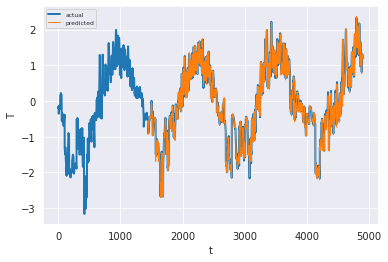

In [24]:
steps = 4

x = model.train_data.time_series[None, 1000:1000 + model.hparams.sequence_length + steps * model.hparams.prediction_length]

xhat = x[:, :-4 * model.hparams.prediction_length]
yhat = model.predict(xhat, steps=steps)
yhat = yhat.detach().cpu().numpy()

plt.plot(np.arange(x.shape[1]), x[0, :, 0], lw=2, label="actual")
plt.plot(np.arange(xhat.shape[1], xhat.shape[1] + yhat.shape[1]), yhat[0, :, 0], lw=1, label="predicted")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()

And now on the validation set, first locally:

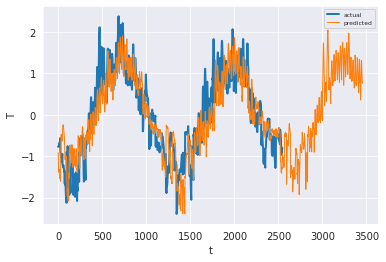

In [25]:
steps = 4
yhat = model.forecast(steps)

plt.plot(val_data[:len(yhat), 0], lw=2, label="actual")
plt.plot(yhat[:, 0], lw=1, label="predicted")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()

and globally:

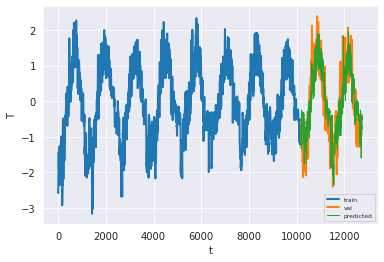

In [27]:
steps = int(round(len(val_data) / model.hparams.prediction_length))
yhat = model.forecast(steps)

x = np.arange(0, len(train_data))
plt.plot(x, train_data[:, 0], lw=2, label="train")
x = np.arange(len(train_data), len(train_data) + len(val_data))
plt.plot(x, val_data[:, 0], lw=2, label="val")
x = np.arange(len(train_data), len(train_data) + len(yhat))
plt.plot(x, yhat[:, 0], lw=1, label="predicted")
plt.xlabel("t")
plt.ylabel("T")
plt.legend()